In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
from sklearn import linear_model
import scipy
import tensorflow as tf
import pandas as pd 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings(action = 'ignore')

In [3]:
def readJson(path):
    data = pd.read_json(path,
                      lines=True,
                      compression='gzip')
    return data

In [4]:
data = readJson("..\\data\\renttherunway_final_data.json.gz")

In [5]:
###########################################################
###.                 Clean up the data                 .###
###########################################################

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192544 non-null  object 
 1   user_id         192544 non-null  int64  
 2   bust size       174133 non-null  object 
 3   item_id         192544 non-null  int64  
 4   weight          162562 non-null  object 
 5   rating          192462 non-null  float64
 6   rented for      192534 non-null  object 
 7   review_text     192544 non-null  object 
 8   body type       177907 non-null  object 
 9   review_summary  192544 non-null  object 
 10  category        192544 non-null  object 
 11  height          191867 non-null  object 
 12  size            192544 non-null  int64  
 13  age             191584 non-null  float64
 14  review_date     192544 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB


In [7]:
# Remove NaNs 
print(data.shape)
weight_na = data.isna().sum()['weight']
height_na = data.isna().sum()['height']
data.isna().sum()

data1 = data.dropna()
print(data1.shape)
# dropping too many entries 
# so fixing weight and height NaNs with average values of respective entries 

(192544, 15)
(146381, 15)


In [8]:
# Convert weight to float and replace NaNs
data['weight'] = data['weight'].fillna("0lbs")

convertweight = lambda x: float(str(x).split("lbs")[0])
data['weight'] = data['weight'].apply(convertweight)
avg_weight = data['weight'].sum() / (data.shape[0] - weight_na)

replaceweight = lambda x: avg_weight if (x==0) else x
data['weight'] = data['weight'].apply(replaceweight)

print(data.dtypes['weight'])
data.isna().sum()['weight']

float64


0

In [9]:
# Convert height to inches and replace NaNs
data['height'] = data['height'].fillna("0' 0'")

convertheight = lambda x: int(x.split(' ')[0][:-1])*12 + int(x.split(' ')[1][:-1])
data['height'] = data['height'].apply(convertheight)
avg_height = data['height'].sum() / (data.shape[0] - height_na)

replaceheight = lambda x: avg_weight if (x==0) else x
data['height'] = data['height'].apply(replaceheight)

print(data.dtypes['height'])
data.isna().sum()['height']

float64


0

In [10]:
# # Convert date to nice format 
# data['review_date'] = data['review_date'].astype('datetime64')
# data['review_year'] = data['review_date'].dt.year
# data['review_month'] = data['review_date'].dt.month


In [11]:
review_length = lambda x: len(x)
review_words = lambda x: len(x.split(' '))
count_ex = lambda x: x.count('!')
data["review_length"] = data["review_text"].apply(review_length)
data["review_words"] = data["review_text"].apply(review_words)
data["review_ex"] = data["review_text"].apply(count_ex)

In [12]:
data = data.dropna()
data.shape

(165128, 18)

In [13]:
data_shuffled = data.sample(frac=1).reset_index()
data_train = data_shuffled[0:int(0.75*len(data))]
data_test = data_shuffled[int(0.75*len(data)):]

data_small = data_train[data_train["fit"].isin(['small'])]
data_large = data_train[data_train["fit"].isin(['large'])]

In [14]:
from numpy.random.mtrand import randint
getsmall = lambda x: (x-randint(0,4))
iheight = lambda x: (x+randint(0,10))
dheight = lambda x: (x-randint(0,10))
getlarge = lambda x: (x+randint(0,4))
d1 = data_small
d2 = data_large
d1["size"] = d1["size"].apply(getsmall)
d1["height"] = d1["height"].apply(iheight)
d2["size"] = d2["size"].apply(getlarge)
d2["height"] = d2["height"].apply(dheight)

In [15]:
feature_list = []
data_new = pd.concat([data_train, d1, d2], ignore_index=True, sort=False)
#features to consider for the model 
bustsize = lambda x: int(x[0:2])
data_new["bust size"] = data_new["bust size"].apply(bustsize)
data_test["bust size"] = data_test["bust size"].apply(bustsize)

In [16]:
data_new = data_new.dropna()
data_new = data_new.drop(data_new[data_new['rented for']== "party: cocktail"].index)

# 0 = Small, 1 = Fit, 2 = Large
data_new.loc[data_new["fit"] == "small", "fit"] = 1

data_new.loc[data_new["fit"] == "fit", "fit"] = 0

data_new.loc[data_new["fit"] == "large", "fit"] = 2

In [17]:
data_test = data_test.dropna()
data_test = data_test.drop(data_test[data_test['rented for']== "party: cocktail"].index)

# 0 = Small, 1 = Fit, 2 = Large
data_test.loc[data_test["fit"] == "small", "fit"] = 1

data_test.loc[data_test["fit"] == "fit", "fit"] = 0

data_test.loc[data_test["fit"] == "large", "fit"] = 2

In [18]:
data_new_dict = pd.DataFrame(data_new).to_dict('record')

for d in data_new_dict:
    d['weight'] = int(d['weight'])#.split('lbs')[0])
    d['height'] = int(d['height'])#.split(' ')[0][:-1])*12 + int(d['height'].split(' ')[1][:-1])

categories = ['rented for','body type']
for cat in categories:
    categories_list = defaultdict(int)
    for d in data_new_dict:
        categories_list[d[cat]] += 1
        
    categories_id = defaultdict(int)

    i = 0
    for cID in  categories_list:
        categories_id[cID] = i
        i+=1
    for d in data_new_dict:
        f = [0]*len(categories_list)
        f[categories_id[d[cat]]] = 1
        d[cat] = f[:len(categories_list)-1]

In [19]:
data_test_dict = pd.DataFrame(data_test).to_dict('record')

for d in data_test_dict:
    d['weight'] = int(d['weight'])#.split('lbs')[0])
    d['height'] = int(d['height'])#.split(' ')[0][:-1])*12 + int(d['height'].split(' ')[1][:-1])

categories = ['rented for','body type']
for cat in categories:
    categories_list = defaultdict(int)
    for d in data_test_dict:
        categories_list[d[cat]] += 1
        
    categories_id = defaultdict(int)

    i = 0
    for cID in categories_list:
        categories_id[cID] = i
        i+=1
    for d in data_test_dict:
        f = [0]*len(categories_list)
        f[categories_id[d[cat]]] = 1
        d[cat] = f[:len(categories_list)-1]

In [38]:
def feature(d):
    f = [d['rating'], 
         d['size'], 
        d['height'], 
        d['weight']]
    f += d['rented for']
    
    f += d['body type']
    arr = []
    review = d['review_text']
    try:
        arr += list(sum([get_word_embeddings(word) for word in review.split() if word not in stop_words])/len([get_word_embeddings(word) for word in review.split()]))
    except:
        arr += [0]*100
    
    f += arr
    arr = []
    review_summary = d['review_summary']
    try:
        arr += list(sum([get_word_embeddings(word) for word in review_summary.split() if word not in stop_words])/len([get_word_embeddings(word) for word in review_summary.split()]))
    except:
        arr += [0]*100
    
    f += arr
    
    return f

In [39]:
i = 0
for d in data_new_dict:
    if i >5:
        break
    print(len(feature(d)))
    i += 1

217
217
217
217
217
217


In [40]:
traindata = data_new_dict
testdata = data_test_dict
X_train = [feature(d) for d in traindata]
X_test = [feature(d) for d in testdata]
y_train = [d['fit'] for d in traindata]
y_test = [d['fit'] for d in testdata]
scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.fit_transform(X_test)

In [45]:
len(X_train[-1])

217

In [46]:
import pickle
datadict = {}
datadict["X_train"] = X_train 
datadict["X_test"] = X_test
datadict["y_train"] = y_train
datadict["y_test"] = y_test
with open('augmented_data_best_model_100.pkl', 'wb') as handle:
    pickle.dump(datadict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
import keras.backend as K


In [48]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [49]:
import pickle as pkl

with open('augmented_data_best_model_100.pkl', 'rb') as f:
    data = pkl.load(f)

X_train = data["X_train"] 
X_test = data["X_test"]
y_train = data["y_train"]
y_test= data["y_test"]

In [50]:
y_train = np.array(y_train)
categories, y_train_categorical = np.unique(y_train, return_inverse=True)

y_test = np.array(y_test)
categories, y_test_categorical = np.unique(y_test, return_inverse=True)

def one_hot_encoding(y_categorical):
    n = y_categorical.shape[0]
    m = np.max(y_categorical) + 1
    y_one_hot = np.zeros([n, m])
    for i in range(n):
        if y_categorical[i] == 0:
            y_one_hot[i, 0] = 1
        elif y_categorical[i] == 1:
            y_one_hot[i, 1] = 1
        elif y_categorical[i] == 2:
            y_one_hot[i, 2] = 1
    return y_one_hot

y_train_one_hot = one_hot_encoding(y_train_categorical)

y_test_one_hot = one_hot_encoding(y_test_categorical)


In [51]:
X_train_array = np.array(X_train)

X_test_array = np.array(X_test)

In [52]:
X_train_array.shape, y_train_one_hot.shape

((156400, 217), (156400, 3))

In [53]:
model = Sequential()
model.add(Dense(60, input_shape = (len(X_train[0]), ), activation = "relu"))
model.add(Dense(40, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(3, activation = "softmax"))
model.compile(Adam(lr = 0.001), "categorical_crossentropy", metrics = ['acc',f1_m,precision_m, recall_m])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                13080     
                                                                 
 dense_1 (Dense)             (None, 40)                2440      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 123       
                                                                 
Total params: 15,643
Trainable params: 15,643
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.fit(X_train_array, y_train_one_hot, verbose=1, epochs=20)

Epoch 1/20
4888/4888 [==============================] - 17s 3ms/step - loss: 0.9406 - acc: 0.5926 - f1_m: 0.5546 - precision_m: 0.6273 - recall_m: 0.5032
Epoch 2/20
4888/4888 [==============================] - 15s 3ms/step - loss: 0.8718 - acc: 0.6127 - f1_m: 0.5854 - precision_m: 0.6489 - recall_m: 0.5366
Epoch 3/20
4888/4888 [==============================] - 15s 3ms/step - loss: 0.8559 - acc: 0.6227 - f1_m: 0.5962 - precision_m: 0.6598 - recall_m: 0.5466: 6s - loss: 0.8574 - acc: 0.6216 - f1_m: - ETA: 3s - loss: 0.8571 - acc: 0.6220 - f1
Epoch 4/20
4888/4888 [==============================] - 15s 3ms/step - loss: 0.8461 - acc: 0.6289 - f1_m: 0.6056 - precision_m: 0.6660 - recall_m: 0.5578
Epoch 5/20
4888/4888 [==============================] - 15s 3ms/step - loss: 0.8395 - acc: 0.6329 - f1_m: 0.6129 - precision_m: 0.6661 - recall_m: 0.5696: 8s - loss: 0.8 - ETA: 4s - loss: 0
Epoch 6/20
4888/4888 [==============================] - 15s 3ms/step - loss: 0.8350 - acc: 0.6368 - f1_m: 0.6

Test Accuracy: 0.6591734896565089
Test F1 Score: 0.6363032336464579
Test Precision Score: 0.6193075671055305
Test Recall Score: 0.6591734896565089
              precision    recall  f1-score   support

           0       0.76      0.84      0.80     30363
           1       0.24      0.16      0.19      5615
           2       0.20      0.16      0.18      5304

    accuracy                           0.66     41282
   macro avg       0.40      0.38      0.39     41282
weighted avg       0.62      0.66      0.64     41282



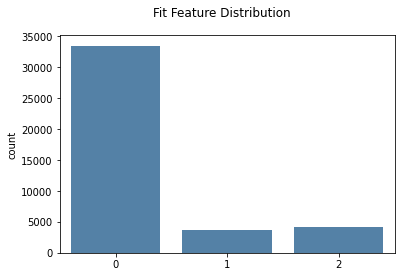

In [55]:
ypred = model.predict(X_test).argmax(axis=1)

test_accuracy = accuracy_score(y_test_categorical, ypred)
test_f1_score = f1_score(y_test_categorical, ypred, average='weighted')
test_precision_score = precision_score(y_test_categorical, ypred, average='weighted')
test_recall_score = recall_score(y_test_categorical, ypred, average='weighted')

print('Test Accuracy:', test_accuracy)
print('Test F1 Score:', test_f1_score)
print('Test Precision Score:', test_precision_score)
print('Test Recall Score:', test_recall_score)
fig = sns.countplot(ypred, color='steelblue').get_figure()
fig.suptitle("Fit Feature Distribution")
fig.savefig("Best_Model_With_embeddings_50_augmentation.png")

from sklearn.metrics import classification_report
print(classification_report(y_test_categorical, ypred))

# Without Data Augmentation

In [3]:
dataset = pd.read_pickle("..\\data\\renttherunway_data_processed.pkl")

In [4]:
# bustsize = lambda x: int(x[0:2])
# data["bust size"] = data["bust size"].apply(bustsize)

In [5]:
# feature_list = []

In [6]:
# btype_data = data["body type"].value_counts()
# btypes = list(btype_data.keys())
# feature_list += (btypes)
# for btype in btypes:
#   bfun = lambda x: 1 if (x==btype) else 0
#   data[btype] = data["body type"].apply(bfun)

In [7]:
# rtype_data = data["rented for"].value_counts()
# rtypes = list(rtype_data.keys())
# feature_list += rtypes
# for rtype in rtypes:
#   rfun = lambda x: 1 if (x==rtype) else 0
#   data[rtype] = data["body type"].apply(rfun)

In [8]:
dataset = dataset.dropna()
dataset = dataset.drop(dataset[dataset['rented for']== "party: cocktail"].index)

# 0 = Small, 1 = Fit, 2 = Large
dataset.loc[dataset["fit"] == "small", "fit"] = 1

dataset.loc[dataset["fit"] == "fit", "fit"] = 0

dataset.loc[dataset["fit"] == "large", "fit"] = 2

In [9]:
data = pd.DataFrame(dataset).to_dict('record')

for d in data:
    d['weight'] = int(d['weight'])#.split('lbs')[0])
    d['height'] = int(d['height'])#.split(' ')[0][:-1])*12 + int(d['height'].split(' ')[1][:-1])

catogeries = ['rented for','body type']
for cat in catogeries:
    categories_list = defaultdict(int)
    for d in data:
        categories_list[d[cat]] += 1
        
    categories_id = defaultdict(int)

    i = 0
    for cID in  categories_list:
        categories_id[cID] = i
        i+=1
    for d in data:
        f = [0]*len(categories_list)
        f[categories_id[d[cat]]] = 1
        d[cat] = f[:len(categories_list)-1]

In [10]:
embeddings_dict = {}
with open("..\\data\\glove.6B.100d.txt", 'rb') as f:
    for line in f:
        values = line.split()
        word = values[0].decode('utf8', 'strict')
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [11]:
def get_word_embeddings(word):
    try:
        return embeddings_dict[word]
    except KeyError:
        return np.zeros(100)

In [12]:
punctuation = set(string.punctuation)
type(embeddings_dict['the'])

numpy.ndarray

In [13]:
stop_words=["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]

In [15]:
df = []
i = 0
for d in data:
    arr = []
    arr.append(d['rating'])
    arr += d['rented for']
    try:
        arr += list(sum([get_word_embeddings(word) for word in d['review_text'].split() if word not in stop_words])/len([get_word_embeddings(word) for word in d['review_text'].split() if word not in stop_words]))
    except:
        arr += [0]*100
    
    try:
        arr += list(sum([get_word_embeddings(word) for word in d['review_summary'].split() if word not in stop_words])/(len([get_word_embeddings(word) for word in d['review_summary'].split() if word not in stop_words])+1))
    except:
        arr += [0]*100
    
    arr += d['body type']
    arr.append(d['size'])
    i += 1
    if i%1000 == 0:
        print(i)
    df.append(arr)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [16]:
len(df[1])

215

In [19]:
y = dataset["fit"]
y_cat = to_categorical(y)
split_ratio = .85
# Split data
test_y = y_cat[int(len(y_cat) * split_ratio):]
train_y = y_cat[:int(len(y_cat) * split_ratio)]
test_f = df[int(len(y_cat) * split_ratio):]
train_f = df[:int(len(y_cat) * split_ratio)]

# Convert to numpy array.
test_f = np.array(test_f)
train_f = np.array(train_f)

In [20]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
model = Sequential()
model.add(Dense(60, input_shape = (len(train_f[0]), ), activation = "relu"))
model.add(Dense(40, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(3, activation = "softmax"))
model.compile(Adam(lr = 0.001), "categorical_crossentropy", metrics = ['acc',f1_m,precision_m, recall_m])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                12960     
                                                                 
 dense_1 (Dense)             (None, 40)                2440      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 123       
                                                                 
Total params: 15,523
Trainable params: 15,523
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(train_f, train_y, verbose=1, epochs=20)

Epoch 1/20
4387/4387 [==============================] - 16s 3ms/step - loss: 0.6770 - acc: 0.7459 - f1_m: 0.7375 - precision_m: 0.7762 - recall_m: 0.7041
Epoch 2/20
4387/4387 [==============================] - 14s 3ms/step - loss: 0.6524 - acc: 0.7547 - f1_m: 0.7472 - precision_m: 0.7831 - recall_m: 0.7158
Epoch 3/20
4387/4387 [==============================] - 14s 3ms/step - loss: 0.6437 - acc: 0.7571 - f1_m: 0.7511 - precision_m: 0.7851 - recall_m: 0.7210
Epoch 4/20
4387/4387 [==============================] - ETA: 0s - loss: 0.6373 - acc: 0.7601 - f1_m: 0.7533 - precision_m: 0.7865 - recall_m: 0.723 - 14s 3ms/step - loss: 0.6375 - acc: 0.7600 - f1_m: 0.7533 - precision_m: 0.7864 - recall_m: 0.7239
Epoch 5/20
4387/4387 [==============================] - 14s 3ms/step - loss: 0.6333 - acc: 0.7612 - f1_m: 0.7555 - precision_m: 0.7875 - recall_m: 0.7270
Epoch 6/20
4387/4387 [==============================] - 14s 3ms/step - loss: 0.6292 - acc: 0.7624 - f1_m: 0.7569 - precision_m: 0.7879 -

In [23]:
predict_x=model.predict(test_f) 
y_pred_class=np.argmax(predict_x,axis=1)

In [24]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(test_f)
y_test_class = np.argmax(test_y, axis=1)
confusion_matrix(y_test_class, y_pred_class)

array([[17305,   477,   461],
       [ 2311,   794,   224],
       [ 2282,   180,   736]], dtype=int64)

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_class, y_pred_class).round(4)

0.7604

In [26]:
for i in y_pred_class:
    if y_pred_class[i]==0:
        y_pred_class[i]=1
        continue
    if y_pred_class[i]==1:
        y_pred_class[i]=0
        continue

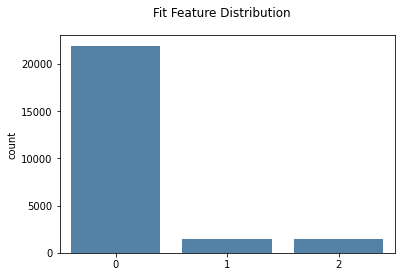

In [27]:
import seaborn as sns
fig = sns.countplot(y_pred_class, color='steelblue').get_figure()
fig.suptitle("Fit Feature Distribution")
fig.savefig("Best_model_word_embeddings_100.png")

In [34]:
dataset['body type']

0                 hourglass
1         straight & narrow
3                      pear
4                  athletic
5                  athletic
                ...        
192539            hourglass
192540               petite
192541    straight & narrow
192542                 pear
192543             athletic
Name: body type, Length: 165127, dtype: object